In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import json
import os

In [ ]:
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 96857, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 96857 (delta 34), reused 40 (delta 14), pack-reused 96720
Receiving objects: 100% (96857/96857), 611.05 MiB | 26.54 MiB/s, done.
Resolving deltas: 100% (70446/70446), done.
cp: cannot stat '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf': No such file or directory


In [ ]:
! cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . \
    && python3 -m pip install .


Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

In [ ]:
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [ ]:
def categorize_waste(category):
    dry_waste = ["Aluminium foil", "Battery", "Aluminium blister pack", "Carded blister pack", "Other plastic bottle",
                 "Broken glass", "Food Can", "Aerosol", "Toilet tube", "Other carton", "Egg carton", "Pizza box",
                 "Garbage bag", "Crisp packet", "Spread tub", "Tupperware", "Disposable food container",
                 "Foam food container", "Other plastic container", "Plastic gloves", "Plastic utensils",
                 "Rope & strings", "Shoe", "Styrofoam piece", "Unlabeled litter", "Cigarette", "Disposable plastic cup",
                 "Foam cup", "Glass cup", "Other plastic cup"]

    wet_waste = ["Food waste"]

    recyclable_waste = ["Clear plastic bottle", "Glass bottle", "Plastic bottle cap", "Metal bottle cap",
                        "Drink can", "Drink carton", "Corrugated carton", "Meal carton", "Magazine paper",
                        "Wrapping paper", "Normal paper", "Paper bag", "Plastified paper bag", "Plastic film",
                        "Six pack rings", "Other plastic wrapper", "Single-use carrier bag", "Polypropylene bag",
                        "Pop tab", "Scrap metal", "Plastic straw", "Paper straw", "Glass jar", "Plastic lid",
                        "Metal lid", "Other plastic"]

    non_recyclable_waste = ["Other plastic bottle", "Broken glass", "Food Can", "Toilet tube", "Egg carton",
                            "Other carton", "Disposable plastic cup", "Other plastic cup", "Styrofoam piece",
                            "Unlabeled litter", "Cigarette"]

    e_waste = ["Battery"]

    biodegradable_waste = ["Food waste"]

    waste_types = []

    if category in dry_waste:
        waste_types.append("Dry")
    if category in wet_waste:
        waste_types.append("Wet")
    if category in recyclable_waste:
        waste_types.append("Dry, Recyclable")
    if category in non_recyclable_waste:
        waste_types.append("Non-Recyclable")
    if category in e_waste:
        waste_types.append("E-Waste")
    if category in biodegradable_waste:
        waste_types.append("Wet, Biodegradable")

    return waste_types

def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=15)

            for i in range(len(boxes)):
                for j, score in enumerate(scores[i]):
                    if score > 0:
                        ymin, xmin, ymax, xmax = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
                        class_index = int(classes[i][j])
                        class_name = category_index[class_index]['name']

                        waste_types = categorize_waste(class_name)
                        print(f'\nBounding box {j+1}: \nLabel={class_name}\n Score={score:.2f} ')
                        print("Waste types:", waste_types)

            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()





In [ ]:
!pip install kaggle



In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d kneroma/tacotrashdataset

100% 2.78G/2.79G [00:34<00:00, 118MB/s]
100% 2.79G/2.79G [00:34<00:00, 87.6MB/s]


In [ ]:
!unzip tacotrashdataset.zip

Archive:  tacotrashdataset.zip
  inflating: best-checkpoint-003epoch.bin  
  inflating: data/annotations.json   
  inflating: data/batch_1/000000.jpg  
  inflating: data/batch_1/000001.jpg  
  inflating: data/batch_1/000003.jpg  
  inflating: data/batch_1/000004.jpg  
  inflating: data/batch_1/000005.jpg  
  inflating: data/batch_1/000006.jpg  
  inflating: data/batch_1/000007.jpg  
  inflating: data/batch_1/000008.jpg  
  inflating: data/batch_1/000010.jpg  
  inflating: data/batch_1/000011.jpg  
  inflating: data/batch_1/000012.jpg  
  inflating: data/batch_1/000013.jpg  
  inflating: data/batch_1/000014.jpg  
  inflating: data/batch_1/000015.jpg  
  inflating: data/batch_1/000016.jpg  
  inflating: data/batch_1/000017.jpg  
  inflating: data/batch_1/000019.jpg  
  inflating: data/batch_1/000021.jpg  
  inflating: data/batch_1/000022.jpg  
  inflating: data/batch_1/000023.jpg  
  inflating: data/batch_1/000024.jpg  
  inflating: data/batch_1/000025.jpg  
  inflating: data/batch_1/000

In [ ]:
DATA_DIR = '/content/data'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')
NCLASSES = 60

In [ ]:
with open(ANNOTATIONS_FILE) as json_file:
    data = json.load(json_file)

categories = data['categories']

In [ ]:
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = int(category['id'])+1
    item.name = category['name']

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "Aluminium foil"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "Battery"\n',
 '  id: 2\n',
 '}\n',
 'item {\n',
 '  name: "Aluminium blister pack"\n',
 '  id: 3\n',
 '}\n',
 'item {\n',
 '  name: "Carded blister pack"\n',
 '  id: 4\n',
 '}\n',
 'item {\n',
 '  name: "Other plastic bottle"\n',
 '  id: 5\n',
 '}\n',
 'item {\n',
 '  name: "Clear plastic bottle"\n',
 '  id: 6\n',
 '}\n',
 'item {\n',
 '  name: "Glass bottle"\n',
 '  id: 7\n',
 '}\n',
 'item {\n',
 '  name: "Plastic bottle cap"\n',
 '  id: 8\n',
 '}\n',
 'item {\n',
 '  name: "Metal bottle cap"\n',
 '  id: 9\n',
 '}\n',
 'item {\n',
 '  name: "Broken glass"\n',
 '  id: 10\n',
 '}\n',
 'item {\n',
 '  name: "Food Can"\n',
 '  id: 11\n',
 '}\n',
 'item {\n',
 '  name: "Aerosol"\n',
 '  id: 12\n',
 '}\n',
 'item {\n',
 '  name: "Drink can"\n',
 '  id: 13\n',
 '}\n',
 'item {\n',
 '  name: "Toilet tube"\n',
 '  id: 14\n',
 '}\n',
 'it

In [ ]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [ ]:
!kaggle datasets download -d bouweceunen/trained-models-taco-trash-annotations-in-context

 95% 105M/111M [00:01<00:00, 58.1MB/s] 
100% 111M/111M [00:01<00:00, 63.2MB/s]


In [ ]:
!unzip trained-models-taco-trash-annotations-in-context.zip

Archive:  trained-models-taco-trash-annotations-in-context.zip
  inflating: ssd_mobilenet_v2_taco_2018_03_29.engine  
  inflating: ssd_mobilenet_v2_taco_2018_03_29.pb  
  inflating: ssd_mobilenet_v2_taco_2018_03_29.uff  


In [ ]:
detection_graph = reconstruct("/content/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


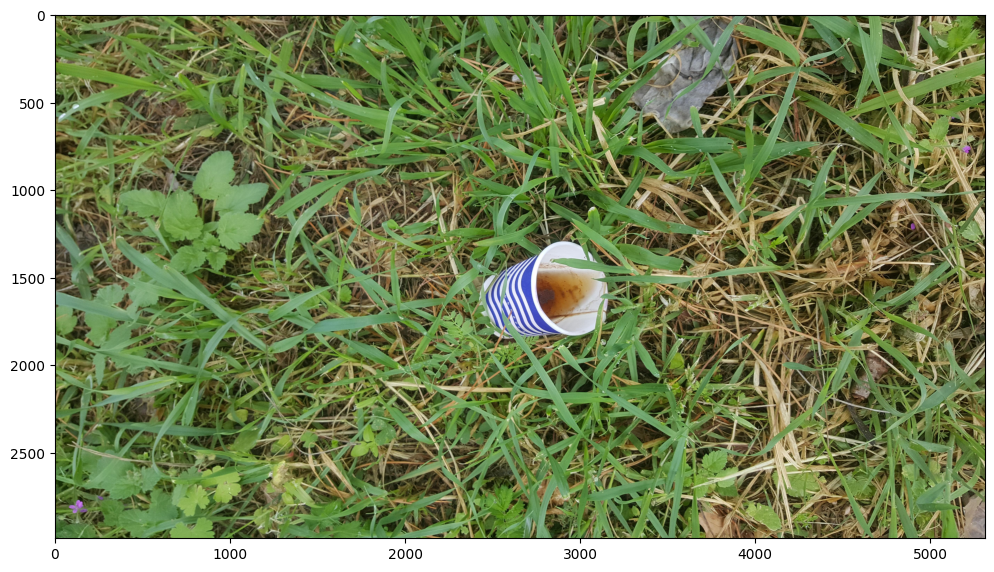

In [ ]:
detect(detection_graph, '/content/data/batch_1/000000.jpg')